In [1]:
!pip install windrose

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define paths to your data
#gps_file = '/content/drive/MyDrive/Cloud data/Serengeti_HMM.csv'
gps_file = 'data/Serengeti_HMM.csv'

# Load GPS data
gps_data = pd.read_csv(gps_file)
gps_data = gps_data[gps_data['case_'] == True]
gps_data['sp_m'] = gps_data['species'] + '_' + gps_data['migrant'].astype(str)
gps_data = gps_data[gps_data['sp_m'] == 'WB_migrant']
gps_data['date1'] = pd.to_datetime(gps_data['date'])
gps_data['date'] = gps_data['date1'].dt.date
gps_data['year'] = gps_data['date1'].dt.year
gps_data['month'] = gps_data['date1'].dt.month
gps_data = gps_data.sort_values(by=['ID','date'])




<xarray.Dataset>
Dimensions:      (time: 106, y: 144, x: 135)
Coordinates:
  * y            (y) float64 1.01e+07 1.01e+07 1.009e+07 ... 9.392e+06 9.388e+06
  * x            (x) float64 3.725e+05 3.775e+05 ... 1.038e+06 1.042e+06
    spatial_ref  int32 21036
  * time         (time) datetime64[ns] 2015-01-31 2015-02-28 ... 2023-10-31
Data variables:
    rainfall     (time, y, x) float32 0.3053 0.3053 0.2937 ... 1.426 1.426 1.53
Attributes:
    crs:           epsg:21036
    grid_mapping:  spatial_ref


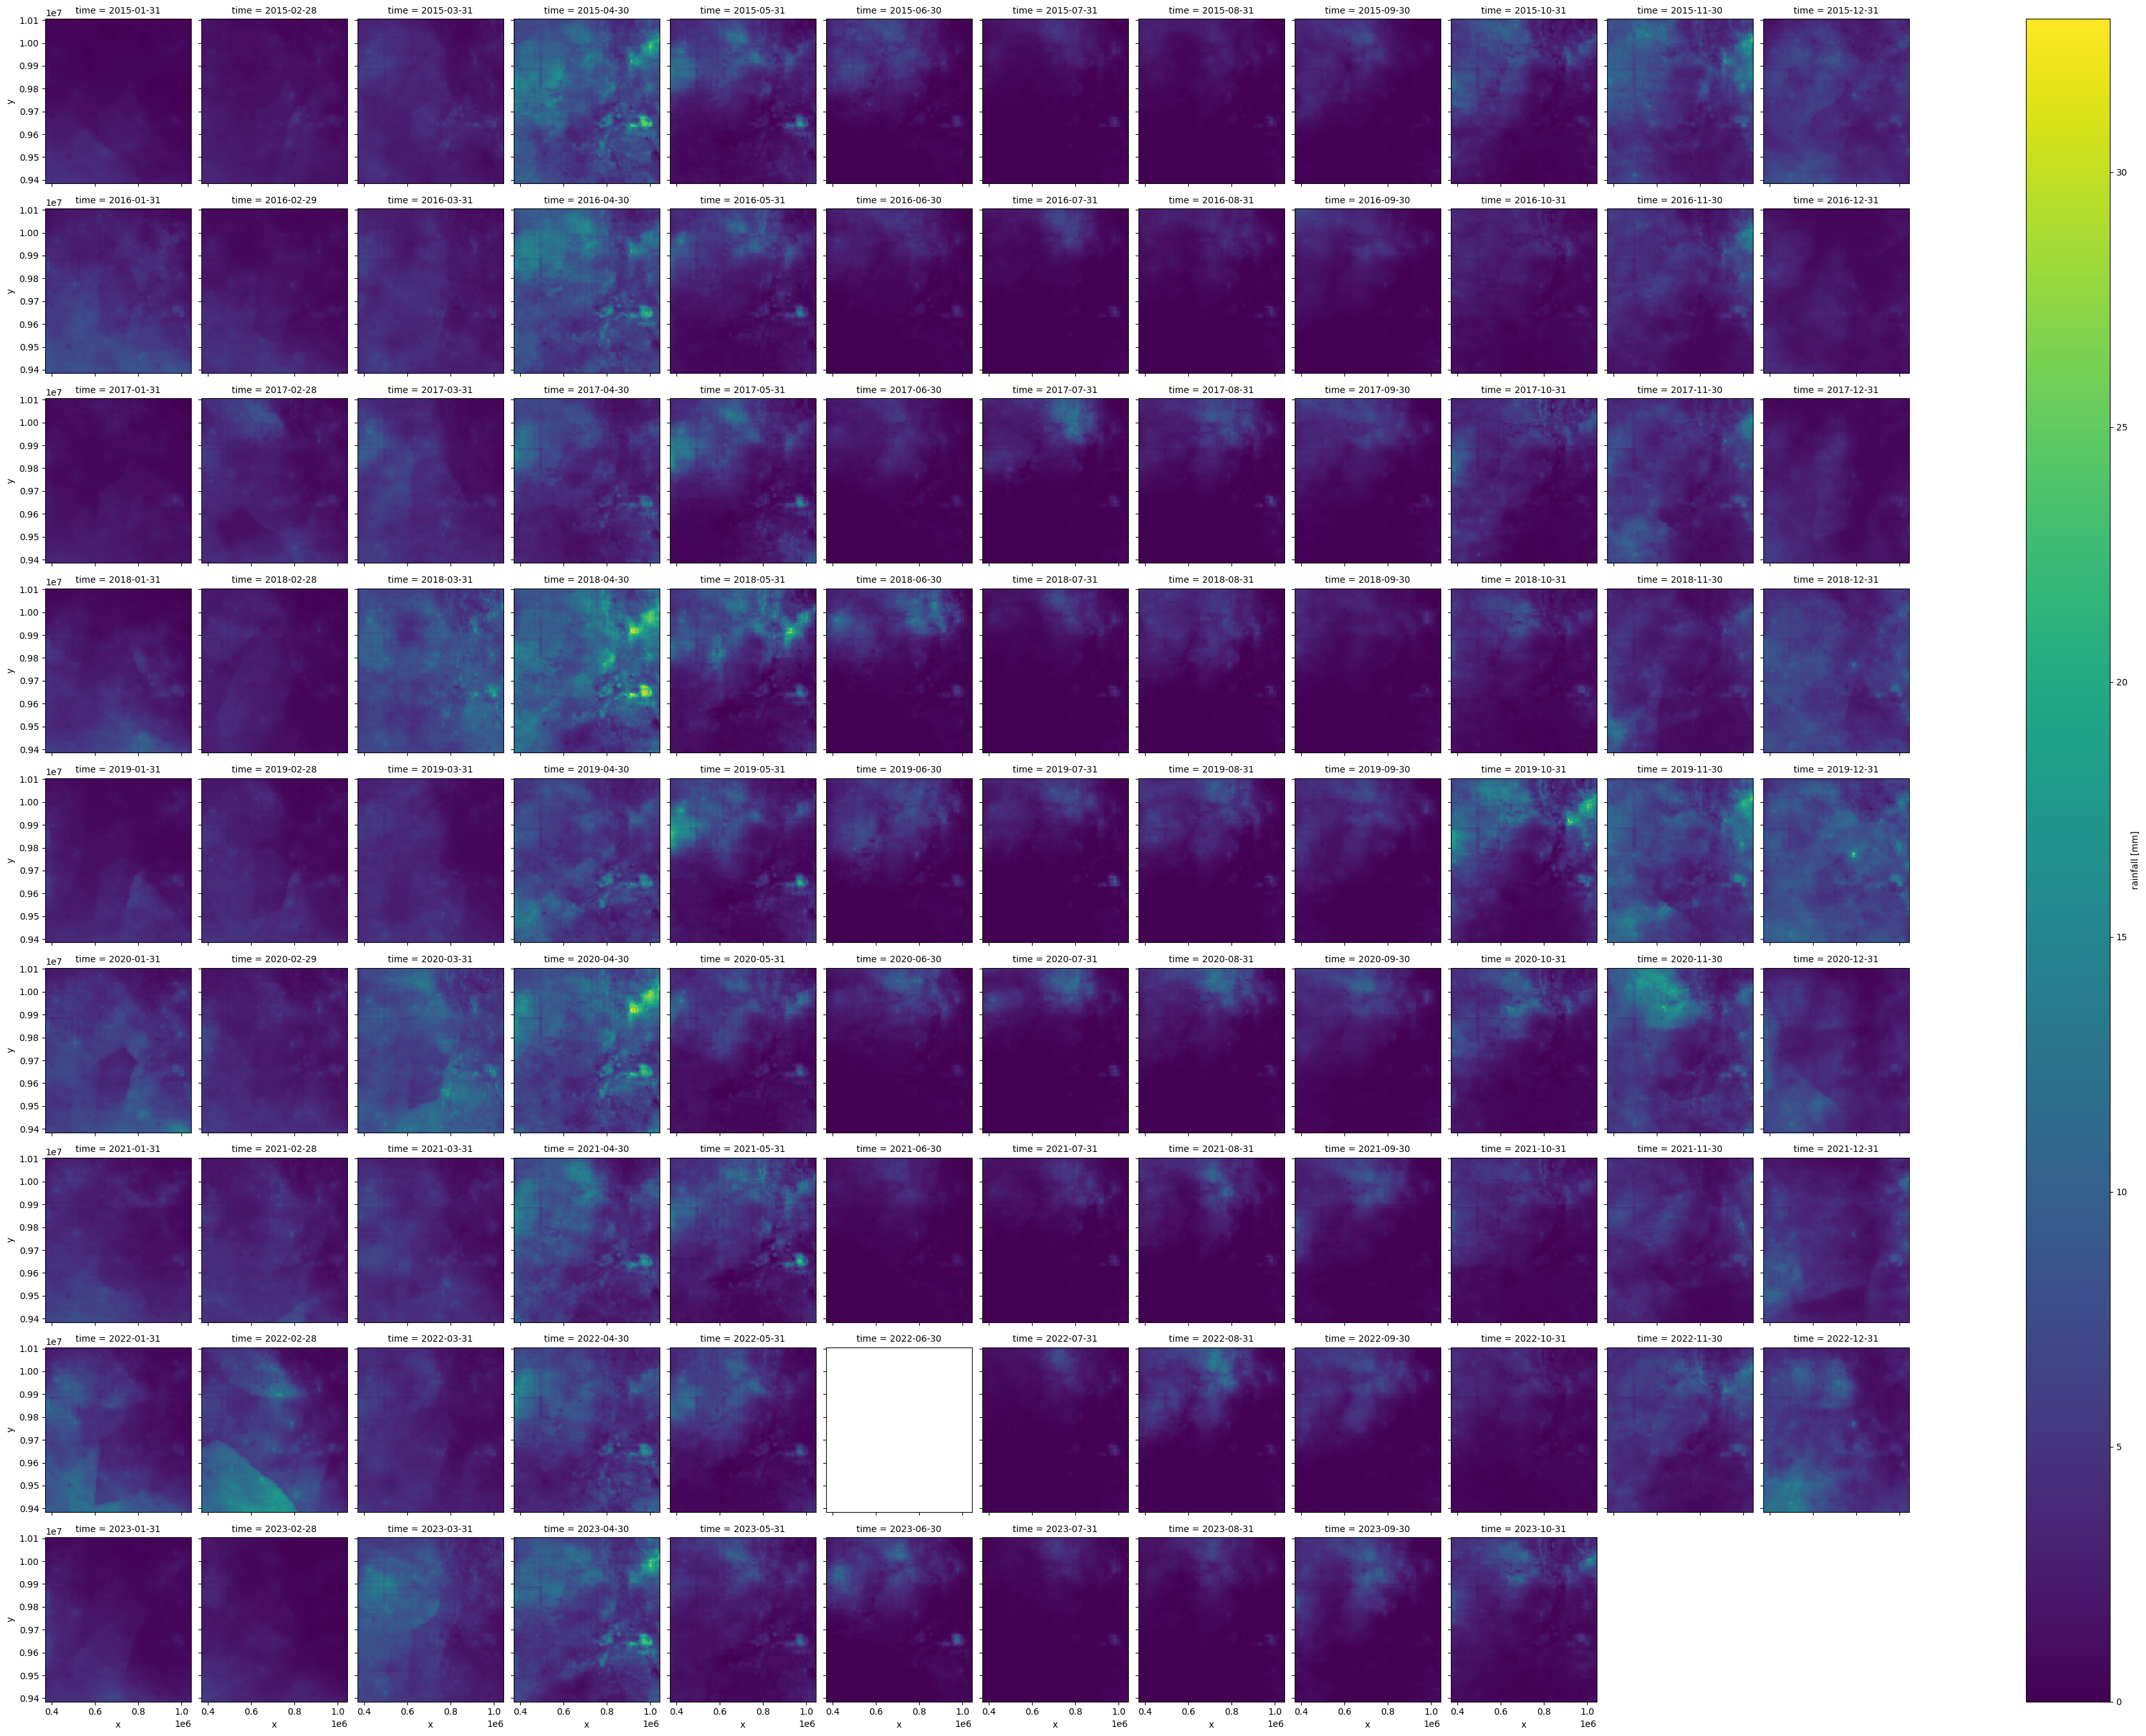

In [4]:
# Load rainfall data
#rain = xr.open_dataset('/content/drive/MyDrive/Cloud data/Serengeti_chirps_wide.nc')
rain = xr.open_dataset('data/Serengeti_chirps_wide.nc')
#threshold = 10
#rain = rain.where(rain['rainfall'] <= threshold, 0)  # Set values below threshold to 0
#rain = rain.where(rain >= threshold, other=np.nan)

# Resample to monthly frequency
monthly_ds = rain.resample(time='1M').mean()

# Print the resulting dataset
print(monthly_ds)
monthly_ds.rainfall.plot(col='time', col_wrap=12)

In [46]:
print(np.abs(np.max(rain['rainfall'].values)))
print(np.min(rain['rainfall'].values))
# any values with np.nan?
print(np.isnan(rain['rainfall'].values).any())

731.3492
0.0
False


In [47]:
rain

<xarray.Dataset>
Dimensions:      (time: 3196, y: 144, x: 135)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01T11:59:59.500000 ... 2023-10...
  * y            (y) float64 1.01e+07 1.01e+07 1.009e+07 ... 9.392e+06 9.388e+06
  * x            (x) float64 3.725e+05 3.775e+05 ... 1.038e+06 1.042e+06
    spatial_ref  int32 21036
Data variables:
    rainfall     (time, y, x) float32 0.0 0.0 4.709 4.661 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           epsg:21036
    grid_mapping:  spatial_ref

In [86]:
from calendar import month
from tqdm import tqdm
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
##
image_size = 32
step = 1
lag = 1

# Create an empty array to store image-GPS pairs
xdata = np.zeros((len(gps_data),image_size,image_size,lag))
ydata = np.zeros((len(gps_data),2))
heading = np.zeros(len(gps_data))
years = np.zeros(len(gps_data))
months = np.zeros(len(gps_data))

i=0
for uid in tqdm(gps_data['ID'].unique()):
    current_data = gps_data[gps_data['ID'] == uid]
    # iterate through every other row
    for index, row in current_data.iterrows():

        # if index % step != 0:
        #     continue

        # Extract GPS coordinates and time from the DataFrame
        center_x = row['x1_']
        center_y = row['y1_']
        center_date = row['date1']
        # find the row that is step days later
        next_date = center_date + pd.Timedelta(days=step)
        next_data = current_data[current_data['date1'] == next_date]
        if len(next_data) == 0:
            continue
        next_x = next_data['x1_'].values[0]
        next_y = next_data['y1_'].values[0]

        # Calculate the heading direction from the current location to the next location
        heading[i] = np.arctan2(next_y - center_y, next_x - center_x)
        heading[i] = np.mod(np.degrees(heading[i]), 360)
        # 0 degrees should be north, but the heading is calculated as 0 degrees being east
        heading[i] = np.mod(90 - heading[i], 360)


        ydata[i] = [next_x - center_x, next_y - center_y]

        # Convert latitude and longitude to indices in the xarray dataset
        x_index = np.abs(rain.x - center_x).argmin().values
        y_index = np.abs(rain.y - center_y).argmin().values

        # Find the index corresponding to the center_time in the time dimension
        time_index = np.abs(rain.time - np.datetime64(center_date)).argmin().values
        if time_index - lag < 0:
            continue

        # Extract a subset of the dataset centered around the specified location for 1 week starting at the current time
        subset = rain.isel(x=slice(x_index - image_size//2, x_index + image_size//2),
                            y=slice(y_index - image_size//2, y_index + image_size//2),
                            time=slice(time_index - lag + 1, time_index+1))

        # Extract the 2D array of the variable you want to visualize
        data_array = subset.rainfall.values

        # Check for NaN and infinite values
        #if np.isnan(data_array).any() or np.isinf(data_array).any():
         #   print(f"Warning: NaN or infinite values found in data_array for ID {uid}, index {index}, time_index {time_index}")
          #  print(f"NaN values: {np.sum(np.isnan(data_array))}")
           # print(f"Infinite values: {np.sum(np.isinf(data_array))}")

        # Handle invalid values by replacing NaN and infinite values with 0
        # normalized_data = np.nan_to_num((data_array - np.min(data_array)) / (np.max(data_array) - np.min(data_array)))
        #data_array = np.nan_to_num(data_array)

        # data_array = np.mean(data_array,axis=0)
        data_array = np.transpose(data_array,[1,2,0])
        xdata[i] = data_array #np.reshape(data_array, (image_size, image_size, 1))
        years[i] = center_date.year
        months[i] = center_date.month
        i += 1


##
print(i)
xdata = xdata[:i]
ydata = ydata[:i]
years = years[:i]
months = months[:i]
heading = heading[:i]

xdata = xdata.astype('float32')
years = years.astype('int32')
months = months.astype('int32')
xdata = xdata / np.percentile(xdata,95) #remove outliers
ydata = ydata.astype('float32')
#ydata = ydata / np.linalg.norm(ydata,axis=1,keepdims=True)
#heading = np.degrees(heading)
##

100%|██████████| 59/59 [01:05<00:00,  1.10s/it]


31390


In [110]:
print(np.max(xdata))
print(np.min(xdata))
xdata_scaled = xdata / np.max(xdata)
print(np.max(xdata_scaled))
print(np.min(xdata_scaled))

17.229967
-2.0182283
1.0
-0.11713477


In [96]:
import numpy as np
from scipy.ndimage import rotate

# Calculate the difference between the true heading and 0 degrees (north)
heading_difference = 0 - heading
print(heading_difference)
# Rotate the heading array to align with 0 degrees (north)
heading_aligned = np.mod(heading + heading_difference, 360)

# Rotate the image data
for i in range(len(xdata)):
    xdata[i] = rotate(xdata[i], -heading_difference[i], reshape=False)

# Now both heading and image are aligned with 0 degrees (north)



[-304.83441435 -173.38004139 -244.07872376 ... -226.39014539 -308.35471803
  -26.16748769]


In [94]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes
from collections import defaultdict
import ipywidgets as widgets

# Step 1: Calculate the average rain per month for each year
average_rain_per_month = {}
for year in np.unique(years):
    for month in range(1, 13):
        mask = (years == year) & (months == month)
        monthly_rain = xdata[mask].mean(axis=0)
        if year not in average_rain_per_month:
            average_rain_per_month[year] = {}
        average_rain_per_month[year][month] = monthly_rain

# Step 1: Calculate the overall minimum and maximum rainfall values
min_rainfall = np.min(xdata)
max_rainfall = np.max(xdata)

# Step 2: Create rasters of average rain per month for each year
def plot_rainfall(year, month):
    plt.figure(figsize=(5, 3))  # Adjust the figure size here
    plt.imshow(average_rain_per_month[year][month], cmap='viridis')#, vmin=min_rainfall, vmax=max_rainfall)  # Set colorbar limits
    plt.title(f'Average Rainfall for {year}-{month}')
    plt.colorbar()
    plt.show()

# Step 3: Create windrose plot for heading directions
def plot_windrose(year, month):
    #plt.figure(figsize=(5, 3))
    indices = np.where((years == year) & (months == month))[0]
    month_headings = heading_aligned[indices]
    ax = WindroseAxes.from_ax(figsize=(6, 4))
    ax.bar(month_headings, var=np.ones_like(month_headings), bins=np.arange(0, 360, 10), normed=True, opening=0.8, edgecolor='white')
    ax.set_title(f'Windrose Plot for {year}-{month}')
    plt.show()

# Create interactive widgets
year_slider = widgets.IntSlider(value=min(years), min=min(years), max=max(years), description='Year')
month_slider = widgets.IntSlider(value=1, min=1, max=12, description='Month')

widgets.interact(plot_rainfall, year=year_slider, month=month_slider)
widgets.interact(plot_windrose, year=year_slider, month=month_slider)


/tmp/ipykernel_498692/776084472.py:11: RuntimeWarning: Mean of empty slice.
  monthly_rain = xdata[mask].mean(axis=0)
/home/no1rabbit/.local/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


interactive(children=(IntSlider(value=2015, description='Year', max=2022, min=2015), IntSlider(value=1, descri…

interactive(children=(IntSlider(value=2015, description='Year', max=2022, min=2015), IntSlider(value=1, descri…

<function __main__.plot_windrose(year, month)>

In [105]:
min_rainfall

-2.0696235

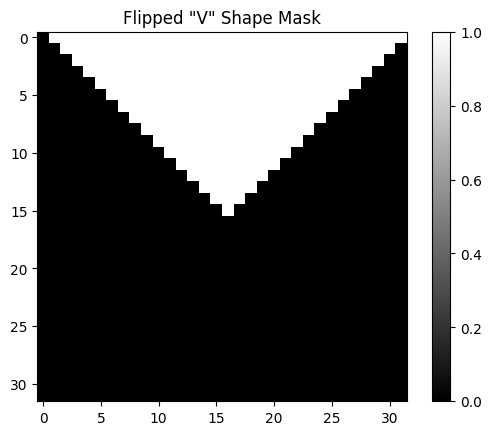

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# Define image size
image_size = 32

# Create a "V" shape mask
v_mask = np.zeros((image_size, image_size))

# Determine the vertical center
center_y = image_size // 2

# Set pixels for the "V" shape
for i in range(center_y, image_size):
    v_mask[i, center_y - (i - center_y):center_y + (i - center_y) + 1] = 1

# Flip the "V" shape mask vertically
v_mask_flipped = np.flipud(v_mask)

# Visualize the flipped "V" shape mask
plt.imshow(v_mask_flipped, cmap='gray')
plt.title('Flipped "V" Shape Mask')
plt.colorbar()
plt.show()




In [103]:
# Initialize lists to store the sums
mask_sums = []
total_sums = []

# Iterate over each image in xdata
for image in xdata:
    # Apply the mask to the image
    masked_image = image[:, :, 0] * v_mask_flipped
    
    # Calculate the sum of pixels with mask value 1
    mask_sum = np.sum(masked_image)
    
    # Calculate the total sum of pixels for the entire image
    total_sum = np.sum(image)
    
    # Append the sums to the lists
    mask_sums.append(mask_sum)
    total_sums.append(total_sum)

# Convert the lists to numpy arrays
mask_sums = np.array(mask_sums)
total_sums = np.array(total_sums)

# Print the results
print("Sum of pixels with mask value 1 for each image:")
print(mask_sums)
print("\nTotal sum of pixels for each image:")
print(total_sums)


Sum of pixels with mask value 1 for each image:
[-2.85172613e-03  9.67461862e+01  1.81239355e+02 ...  1.01508610e+02
  2.10367158e+02  1.18119220e+02]

Total sum of pixels for each image:
[  0.8391211 202.61652   666.6124    ... 533.49054   693.16895
 326.0099   ]


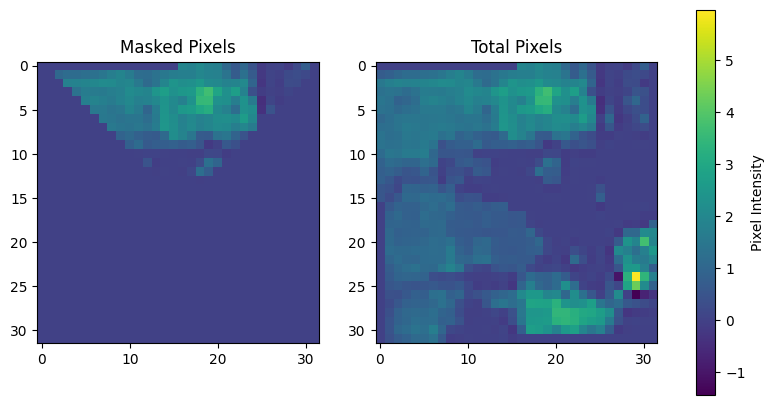

In [100]:
import matplotlib.pyplot as plt

# Choose an index for visualization
index = 131  # You can change this to visualize different samples

# Get the minimum and maximum values for consistent color scale
vmin = min(masked_image.min(), xdata[index][:, :, 0].min())
vmax = max(masked_image.max(), xdata[index][:, :, 0].max())

# Apply the mask to the image
masked_image = xdata[index][:, :, 0] * v_mask_flipped

# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the masked pixels
axs[0].imshow(masked_image, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title('Masked Pixels')

# Plot the total pixels
axs[1].imshow(xdata[index][:, :, 0], cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title('Total Pixels')

# Create a colorbar
cbar = fig.colorbar(axs[1].imshow(xdata[index][:, :, 0], cmap='viridis', vmin=vmin, vmax=vmax), ax=axs, orientation='vertical')

# Set the colorbar label
cbar.set_label('Pixel Intensity')

plt.show()




In [101]:
# Choose an index for visualization
index = 0  # You can change this to visualize different samples
masked_image = xdata[index] * v_mask_flipped
masked_image.shape
#v_mask_flipped
#xdata[index].shape

(32, 32, 32)